<a href="https://colab.research.google.com/github/NaimaZouidi/Frenshi-chatbot/blob/main/Frenshi_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frenshi Chatbot

This notebook trains a chatbot called Frenshi on the administrative formalities in France for foreign students to help them during their stay! It proposes FR and EN versions to help these later regardless of whether they can speak French or not!

# Set-up enviroment
To run this colab notebook you will need to import some python modules such as Tensorflow, pandas, etc. You will also need to install textaugment library to perform text data augmentation in order to improve the chatbot performance. Please click [here](https://github.com/dsfsi/textaugment/tree/master) to learn more about this library and how to use it.



In [1]:
try:
  import textaugment
except ModuleNotFoundError:
  !pip install textaugment

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15718 sha256=8a59586306bf5a68cf2b375a3ccb8206d368b150c4744f90b818bbea7d17aaa7
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling cha

In [2]:
import tensorflow as tf
import random
import pandas as pd
import string
import numpy as np
import json
import nltk
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalAvgPool1D, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from textaugment import EDA
from textaugment import Translate

# Help-in functions

This function creates an NLP model with an LSTM transformer.


```
input_shape: is the length of the user's input.
output_len: is the number of output tags or classes.
```



In [3]:
def createFrenshiModel(input_shape, vocabulary, output_len):
  i = Input(shape=(input_shape))
  x = Embedding(vocabulary + 1, 10)(i)
  x = LSTM(10, return_sequences=True)(x)
  x = Flatten()(x)
  x = Dropout(rate=0.2)(x)
  x = Dense(output_len, activation="softmax")(x)
  model = Model(i, x)
  return model

This function will prepare our dataset so we can convert it to a dataframe afterward. Indeed, our chatbot Frenshi will train on a paire of data ```(user's input, class/tag)``` in order to find the best answer to any user's input.


```
dataset: is the original dataset.
```





In [4]:
def prepare_dataset(dataset):
  tags = []
  inputs = []
  responses = {}
  for intent in dataset["intents"]:
    responses[intent["tag"]] = intent["responses"]
    for text in intent["input"]:
      inputs.append(text)
      tags.append(intent["tag"])
  return inputs, tags, responses

This function will apply the RTT-based augmentation technique on our dataset. This later translate texte from one language to another. Then, retranslate it back in order to create new text data.

```
dataset: respresents the original dataset.
```



In [5]:
def augment_data_with_RTTbased_augmentation(inputs, tags):
  translatorFR = Translate(src="fr", to="en")
  translatorEN = Translate(src="en", to="fr")
  inputs_new = []
  tags_new = []
  for i, text in enumerate(inputs):
      inputs_new.append(text)
      tags_new.append(tags[i])
      try:
        if("FR" in tags[i]):
          augmented_text = translatorFR.augment(text) #Select retranslation from French to English if user's input is in French
        else:
          augmented_text = translatorEN.augment(text) #Select retranslation from English to French if user's input is in English
      except AttributeError:
        continue
      print(augmented_text)
      inputs_new.append(augmented_text)
      tags_new.append(tags[i])
  return inputs_new, tags_new

This function will apply random deletion augmentation technique on our dataset, which will randomly remove each word in the user's input with probability ```p```.




```
dataset: respresents the original dataset.
```

In [6]:
def augment_data_with_random_deletion(inputs, tags):
  inputs_new = []
  tags_new = []
  eda = EDA(random_state=1)
  for i, text in enumerate(inputs):
      inputs_new.append(text)
      tags_new.append(tags[i])
      augmented_text = eda.random_deletion(text, p=0.2)
      print(augmented_text)
      inputs_new.append(augmented_text)
      tags_new.append(tags[i])
  return inputs_new, tags_new

This function will apply random swap data augmentation technique on our dataset which will randomly pick two words in the user's input and swap their positions. It do this ```n```times.



```
dataset: is the original dataset
```



In [7]:
def augment_data_with_random_swap(inputs, tags):
  inputs_new = []
  tags_new = []
  eda = EDA(random_state=1)
  for i, text in enumerate(inputs):
      inputs_new.append(text)
      tags_new.append(tags[i])
      augmented_text = eda.random_swap(text)
      print(augmented_text)
      inputs_new.append(augmented_text)
      tags_new.append(tags[i])
  return inputs_new, tags_new

This function returns some training parameters for our chatbot Frenshi.


```
Tokenizer: is the tokenizer used to tokenize the data.
labelEnc: is the encoder used to encode tags into numeric data.
```



In [8]:
def get_training_parameters(tokenizer, labelEnc):
  vocabulary = len(tokenizer.word_index)
  print("The number of unique words is: ", vocabulary)
  output_len = labelEnc.classes_.shape[0]
  print("The output length is: ", output_len)
  return vocabulary, output_len

This function tokenize the user's input and encode the tag into numeric data in order to train our chatbot Frenshi.


```
dataset: is the dataset.
```



In [9]:
def tokenizeAndEncodeData(dataset):
  tokenizer = Tokenizer(num_words=2000);
  tokenizer.fit_on_texts(dataset['inputs']);
  train = tokenizer.texts_to_sequences(dataset['inputs'])
  #Apply padding
  x_train = pad_sequences(train)
  #Encoding output to numeric data
  labelEnc = LabelEncoder()
  y_train = labelEnc.fit_transform(dataset['tags'])
  return tokenizer, labelEnc, x_train, y_train

# Downloading Dataset
In order to train our chatbot Frenshi we need to download the two training datasets.

P.S: Please refer to [Creating the training datasets for Frenshi Chatbot](https://github.com/NaimaZouidi/Frenshi-chatbot/blob/main/Creating_dataset_for_Frenshi_chatbot.ipynb) for more details on how to create these two datasets.


In [10]:
!curl -o dataset-fr.json -L "https://raw.githubusercontent.com/NaimaZouidi/Frenshi-gui-app/main/Datasets/dataset-fr.json"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 59938  100 59938    0     0   123k      0 --:--:-- --:--:-- --:--:--  123k


In [11]:
!curl -o dataset-en.json -L "https://raw.githubusercontent.com/NaimaZouidi/Frenshi-gui-app/main/Datasets/dataset-en.json"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48015  100 48015    0     0   160k      0 --:--:-- --:--:-- --:--:--  160k


# Importing Dataset
As we saved both datasets as json. we need to import them into a dataframe in order to train our chatbot Frenshi.

In [12]:
with open("dataset-fr.json") as dbfr:
  datasetFR = json.load(dbfr)
with open("dataset-en.json") as dbEN:
  datasetEN = json.load(dbEN)
inputsFR, tagsFR, responsesFR = prepare_dataset(datasetFR)
inputsEN, tagsEN, responsesEN = prepare_dataset(datasetEN)

Here we will perform text data augmentation on our datasets using RTT-based augmentation and Easy Data Augmentation (EDA) from the [textaugment](https://github.com/dsfsi/textaugment) library. Please refer to [Improving short text classification through
global augmentation methods](https://arxiv.org/pdf/1907.03752.pdf) to learn more about these techniques.

In [13]:
nltk.download('stopwords')
inputsFR, tagsFR = augment_data_with_RTTbased_augmentation(inputsFR, tagsFR)
inputsFR, tagsFR = augment_data_with_random_swap(inputsFR, tagsFR)
inputsFR, tagsFR = augment_data_with_random_deletion(inputsFR, tagsFR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


ça marche!
ça marche! passe une bonne journée
ça marche ! merci
ça marche ! au revoir
ça marche ! merci beaucoup
ça marche!
ça marche ! passe une bonne journée
ça marche ! merci
ça marche ! au revoir
ça marche ! merci beaucoup
Error Not translated.

haut ! passe une bonne journée
haut ! merci
haut ! merci beaucoup
haut ! au revoir
d'accord
d'accord ! au revoir !
d'accord! merci !
d'accord ! merci beaucoup
d'accord ! passe une bonne journée
super !
super ! merci !
super ! merci beaucoup
super ! au revoir
super ! passe une bonne journée
au revoir !
au revoir frenshi!
merci beaucoup ! au revoir
merci beaucoup ! au revoir frenshi
oh ! merci beaucoup
oh ! merci beaucoup frenshi
merci beaucoup ! passe une bonne journée
merci beaucoup ! bonne journée frenshi
merci !
merci frenshi!
passe une bonne journée
bonne journée frenshi!
bonne nuit
passe une bonne soirée
d'accord ! passe une bonne soirée
d'accord ! bonne nuit
super ! passe une bonne soirée
ça marche ! passe une bonne soirée
ça marche ! 

In [14]:
inputsEN, tagsEN = augment_data_with_RTTbased_augmentation(inputsEN, tagsEN)
inputsEN, tagsEN = augment_data_with_random_swap(inputsEN, tagsEN)
inputsEN, tagsEN = augment_data_with_random_deletion(inputsEN, tagsEN)

all right!
all right! thanks
all right! thanks a lot
all right! have a nice day
all right! goodbye
all right! goodbye
great! have a nice day
great! thanks
great! thanks a lot
great! goodbye
all right
all right! goodbye
all right! thanks
all right! have a nice day
great! goodbye
goodbye!
Error Not translated.

thanks a lot! goodbye frenshi
oh! thanks a lot
oh! thank you very much frenshi
thanks a lot! have a nice day
thanks a lot! have a good day frenshi
thanks!
thank you frenshi!
have a nice day
have a good day frenshi!
good night
all right! good night
great! good night
great! good night frenshi
all right! good night frenshi
thank you so much! good night
thanks a lot! good night frenshi
thanks a lot!
thanks! good night frenshi
thanks! good night
good night frenshi!
marital status
what is civil status?
civil test
what document for civil status?
which civil status support document?
learn more about civil status
i would like to know more about civil status?
how to validate my visa
where t

After performing text data augmentation on our datasets we will prepare them, then convert them into two dataframes with the following two columns:


```
inputs: the user's input.
tags: the corresponding tag or class to the user's input in order to identify the best answer to it.
```
in order to train our chatbot Frenshi




In [15]:
dataFR = pd.DataFrame({"inputs":inputsFR,"tags":tagsFR})
dataEN = pd.DataFrame({"inputs":inputsEN,"tags":tagsEN})

# Preprocessing
NLP models can't understand text accordangly. So we need to preprocess the user's input in our datasets by removing punctuations and converting it to lowercase.

In [16]:
dataFR['inputs'] = dataFR["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
dataFR['inputs'] = dataFR["inputs"].apply(lambda wrd: ''.join(wrd))

In [17]:
dataEN['inputs'] = dataEN["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
dataEN['inputs'] = dataEN["inputs"].apply(lambda wrd: ''.join(wrd))

Since text data augmentation techniques may result in redundant user's input especially in the case of retranslation, we will clean our datasets from redundant user's inputs so that the models don't overfit these later.

In [18]:
dataFR=dataFR.drop_duplicates()
dataEN=dataEN.drop_duplicates()

In [19]:
dataFR.head(200)
dataEN.head(200)

,inputs,tags
0,okay,goodbyeDay EN
4,all right,goodbyeDay EN
5,right,goodbyeDay EN
6,right all,goodbyeDay EN
8,okay thank you,goodbyeDay EN
...,...,...
320,what document for civil status,Civil state EN
322,what for document civil status,Civil state EN
323,what document civil status,Civil state EN
324,which supporting document for civil state,Civil state EN


# Tokenizing the dataset
Tokenization is as important as text preprocessing. It converts a sequence of text into smaller parts, also known as tokens. These tokens can be as small as characters or as long as words. The main reason behind this process is that it helps machines understand human language by breaking it down into bite-sized pieces, which are easier to analyze than whole sentences.

In [20]:
#Tokenize the data
tokenizerFR, labelEncFR, x_trainFR, y_trainFR = tokenizeAndEncodeData(dataFR)
tokenizerEN, labelEncEN, x_trainEN, y_trainEN = tokenizeAndEncodeData(dataEN)

In [21]:
input_shapeFR = x_trainFR.shape[1]
print(input_shapeFR)

18


In [22]:
input_shapeEN = x_trainEN.shape[1]
print(input_shapeEN)

18


In [23]:
vocabularyFR, output_lenFR = get_training_parameters(tokenizerFR, labelEncFR)
vocabularyEN, output_lenEN = get_training_parameters(tokenizerEN, labelEncEN)

The number of unique words is:  373
The output length is:  46
The number of unique words is:  239
The output length is:  45


In [24]:
with open( 'word_dict-en.json' , 'w' ) as file:
	json.dump( tokenizerEN.word_index , file )
with open( 'word_dict-en.json' , 'w' ) as file:
	json.dump( tokenizerFR.word_index , file )

# Creating an NLP model to classifier the user's input by tags
Here we'll create and train two NLP models in order to classifier the user's input by tags or classes so we can identify the best answer to it.


In [25]:
modelFR = createFrenshiModel(input_shapeFR, vocabularyFR, output_lenFR)
modelFR.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding (Embedding)       (None, 18, 10)            3740      
                                                                 
 lstm (LSTM)                 (None, 18, 10)            840       
                                                                 
 flatten (Flatten)           (None, 180)               0         
                                                                 
 dropout (Dropout)           (None, 180)               0         
                                                                 
 dense (Dense)               (None, 46)                8326      
                                                                 
Total params: 12906 (50.41 KB)
Trainable params: 12906 (50.41

In [26]:
modelEN = createFrenshiModel(input_shapeEN, vocabularyEN, output_lenEN)
modelEN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 18, 10)            2400      
                                                                 
 lstm_1 (LSTM)               (None, 18, 10)            840       
                                                                 
 flatten_1 (Flatten)         (None, 180)               0         
                                                                 
 dropout_1 (Dropout)         (None, 180)               0         
                                                                 
 dense_1 (Dense)             (None, 45)                8145      
                                                                 
Total params: 11385 (44.47 KB)
Trainable params: 11385 (44.

In [27]:
modelFR.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")
modelEN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [28]:
batch_size = 32
steps_per_epochFR = len(x_trainFR)//batch_size
steps_per_epochEN = len(x_trainEN)//batch_size

In [29]:
historyFR = modelFR.fit(x_trainFR, y_trainFR, batch_size = batch_size, steps_per_epoch= steps_per_epochFR, epochs = 200)
historyEN = modelEN.fit(x_trainEN, y_trainEN, batch_size = batch_size, steps_per_epoch= steps_per_epochEN, epochs = 200)

Epoch 1/200
85/85 [==============================] - 3s 8ms/step - loss: 3.7306 - accuracy: 0.0676
Epoch 2/200
85/85 [==============================] - 1s 8ms/step - loss: 3.4292 - accuracy: 0.1302
Epoch 3/200
85/85 [==============================] - 1s 8ms/step - loss: 3.0181 - accuracy: 0.1905
Epoch 4/200
85/85 [==============================] - 1s 8ms/step - loss: 2.7229 - accuracy: 0.2396
Epoch 5/200
85/85 [==============================] - 1s 9ms/step - loss: 2.5191 - accuracy: 0.2814
Epoch 6/200
85/85 [==============================] - 1s 10ms/step - loss: 2.3433 - accuracy: 0.3199
Epoch 7/200
85/85 [==============================] - 1s 10ms/step - loss: 2.1681 - accuracy: 0.3602
Epoch 8/200
85/85 [==============================] - 1s 12ms/step - loss: 1.9832 - accuracy: 0.4135
Epoch 9/200
85/85 [==============================] - 1s 13ms/step - loss: 1.8230 - accuracy: 0.4682
Epoch 10/200
85/85 [==============================] - 1s 12ms/step - loss: 1.6905 - accuracy: 0.5089
Epoc

# Model analysis
Now, let's plot loss vs accuracy curves to see how well is our model in classifying user's input among the availables tags or classes in our dataset.

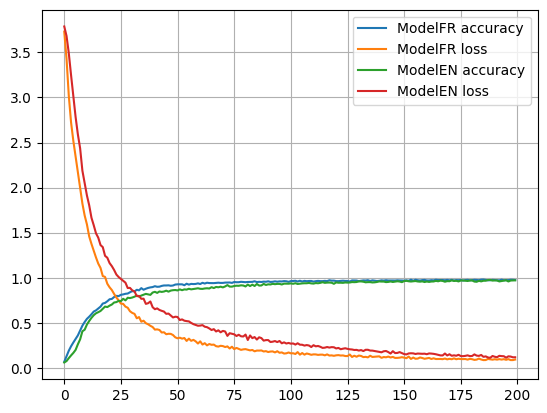

In [30]:
plt.plot(historyFR.history['accuracy'], label = "ModelFR accuracy")
plt.plot(historyFR.history['loss'], label = "ModelFR loss")
plt.plot(historyEN.history['accuracy'], label = "ModelEN accuracy")
plt.plot(historyEN.history['loss'], label = "ModelEN loss")
plt.legend()
plt.grid()

# Testing frenshi
Then, we'll chat a little bit with Frenshi about the administrative formalities in France for foreign students.

In [31]:
lang = input("Veuillez s'il vous plait selectionner une langue/Please select a preferred language: FR, EN ")
if(lang == "FR"):
  print("FrenShi: Bienvenue ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d\'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nValider mon visa, titre de séjour, CAF ou sécurité sociale.")
else :
  print("FrenShi: Welcome! I’m FrenShi! I'm here to help you with your administrative formalities in France. Administrative formalities can be a real headache, especially for foreign students arriving in a new country. But don’t worry! I’ve got you covered! To get started, please type one of the following options:\nValidate my visa, resident permit, CAF or health insurance.")
while True:
  texts_p = []
  if(lang == "FR"):
    prediction_input = input("Utilisateur: ")
  else :
    prediction_input = input("User : ")
  #Preprocessing the user's input
  prediction_input = [ltrs.lower() for ltrs in prediction_input if ltrs not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  prediction_inputTmp = prediction_input
  texts_p.append(prediction_input)
  #Tokenizing the user's input
  if(lang == "FR"):
    prediction_input = tokenizerFR.texts_to_sequences(texts_p)
  else:
    prediction_input = tokenizerEN.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  #Apply padding
  #Perform prediction on user's input
  if(lang == "FR"):
    prediction_input = pad_sequences([prediction_input], input_shapeFR)
    output = modelFR.predict(prediction_input)
  else:
    prediction_input = pad_sequences([prediction_input], input_shapeEN)
    output = modelEN.predict(prediction_input)
  output = output.argmax()
  #Convert model output back to text
  if(lang == "FR"):
    response_tag = labelEncFR.inverse_transform([output])[0]
    print("Frenshi: ", random.choice(responsesFR[response_tag]))
  else :
    response_tag = labelEncEN.inverse_transform([output])[0]
    print("Frenshi: ", random.choice(responsesEN[response_tag]))
  #print the best answer to the user's input
  if response_tag == "goodbyeDay FR" or response_tag == "goodbyeEvening FR" or response_tag == "goodbyeDay EN" or response_tag == "goodbyeEvening EN":
    break

Veuillez s'il vous plait selectionner une langue/Please select a preferred language: FR, EN FR
FrenShi: Bienvenue ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:
Valider mon visa, titre de séjour, CAF ou sécurité sociale.
Utilisateur: Valider mon visa
1/1 [==============================] - 0s 457ms/step
Frenshi:  Pour lui donner une Valeur de Titre de Séjour (VTS), vous devez valider votre visa dès votre arrivée en France et au plus tard dans les 3 mois suivant votre arrivée. Tous ceux qui ont un visa doivent effectuer cette procédure en ligne.
Par consequent, vous pouvez faire sur le site internet de l'ANEF :https://administration-etrangers-en-France.interieur.gouv.fr/particu

Finally, let's save the weights of our chatbot frenshi!

In [32]:
modelFR.save("frenshi-fr.keras")
modelEN.save("frenshi-en.keras")

Run this cell if you also want to convert the NLP models into a TF lite. so, you can deploy them in an android app.

In [33]:
converterFR = tf.lite.TFLiteConverter.from_keras_model(modelFR)
converterFR.optimizations = [tf.lite.Optimize.DEFAULT]
converterFR.experimental_new_converter=True
converterFR.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]
tfLiteModelFR = converterFR.convert()
converterEN = tf.lite.TFLiteConverter.from_keras_model(modelEN)
converterEN.optimizations = [tf.lite.Optimize.DEFAULT]
converterEN.experimental_new_converter=True
converterEN.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]
tfLiteModelEN = converterEN.convert()
with open("model-fr.tflite", "wb") as fileFR:
  fileFR.write(tfLiteModelFR)
with open("model-en.tflite", "wb") as fileEN:
  fileEN.write(tfLiteModelEN)